# **Crime Analysis**
Joseph Kim and Zak Khan

We found a crime dataset that was exceptionally large. The original file measured roughly 1.6 gb. We wanted to analyze this data to measure crime and reveal statistics regarding cases in Alabama. This dataset included over a million crime incidents.

Our goal is to analyze the dataset to find patterns that could help us see correlations between different features of our specific crime data and make a modle to classify for whether an incident is violent or not. We will employ Random Forests to identify the most important variables before using Naive Bayes to accomplish this classification task.

We used PCA, chunking, and dask to reduce the dimensionality of the dataset, allowing us to focus on the most critical components that influence crime patterns while simplifying the data for more efficient and effective modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

After we imported necessary packages, we began by attempting to use Dask services to import our data efficiently.

In [ ]:
import dask.dataframe as ddf
from google.colab import drive

drive.mount('/content/drive')
# Use Dask to read the CSV file
dask_df = ddf.read_csv("/content/drive/My Drive/Colab Notebooks/Individual_Incident_2020.csv")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive


In [ ]:
print(dask_df)

Dask DataFrame Structure:
                 state      ID     ORI incident_number date_HRF date_SIF    hour total_offense total_victim total_offender violence_offense theft_offense drug_offense sex_offense kidnapping_trafficking other_offense gun_involvement drug_involvement property_value stolen_motor male_victim female_victim unknown_sex_victim w_victim b_victim i_victim a_victim p_victim unknown_race_victim minor_victim non_minor_victim unknown_age_victim offender_wi_family offender_outside_family offender_not_known male_offender female_offender unknown_sex_offender w_offender b_offender i_offender a_offender p_offender unknown_race_offender minor_offender non_minor_offender unknown_age_offender completed_attempted2 completed_attempted3 property_description property_description2 property_description3 race_offender2
npartitions=25                                                                                                                                                             

Dask was used to deal with a large dataset, but we ultimately decided that with this dataset type needs to have more dynamic access. Dask changed our data representation more than we'd like, so we opted to use chunking in order to reduce the computational expense of running such a huge dataset.

In [ ]:
#load data set through chunking a dataset and putting it through 2 empty dataframe
chunk_size = 500000
chunky_df = pd.DataFrame()
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Individual_Incident_2020.csv",
                   chunksize = chunk_size)
#creation of 2 emtpy dataframes
df1 = pd.DataFrame()
df2 = pd.DataFrame()
#df3 = pd.DataFrame()
#load the datas and assign them to differing datasets
for i, chunk in enumerate(data):
    if i % 3 == 0:
        df1 = pd.concat([df1, chunk], ignore_index=True)
    elif i % 3 == 1:
        df2 = pd.concat([df2, chunk], ignore_index=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We created a chunked variation of a dataset where the chunk size is 500,000. This chunked data was split into 2 datasets to work with each more easily when training and testing. We then dropped some columns that were unquantifiable and arbitrarily determined as unnecessary due to various factors. Then we imputed missing data with 0 values to mimic a null value in order to keep most of the data for the test train split. We opted to only use one chunk of the data we loaded because the RAM demands were too high for runnable analysis after loading the data.

In [ ]:
def dropper(dataframe):
  dataframe = dataframe.drop(['state', 'ID', 'ORI',	'incident_number',
             'date_HRF', 'date_SIF', 'hour'], axis = 1)
  for column in dataframe:
    dataframe[column] = dataframe[column].replace(' ', 0).astype(float)
  dataframe = dataframe.fillna(0)
  return dataframe

df1 = dropper(df1)
df2 = dropper(df2)

In [ ]:
df1.head()

,total_offense,total_victim,total_offender,violence_offense,theft_offense,drug_offense,sex_offense,kidnapping_trafficking,other_offense,gun_involvement,...,unknown_race_offender,minor_offender,non_minor_offender,unknown_age_offender,completed_attempted2,completed_attempted3,property_description,property_description2,property_description3,race_offender2
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0,0.0


In [ ]:
df2.head()

,total_offense,total_victim,total_offender,violence_offense,theft_offense,drug_offense,sex_offense,kidnapping_trafficking,other_offense,gun_involvement,...,unknown_race_offender,minor_offender,non_minor_offender,unknown_age_offender,completed_attempted2,completed_attempted3,property_description,property_description2,property_description3,race_offender2
0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,77.0,38.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,25.0,65.0,9.0,0.0


We created a 75:25 train test split for each chunk of the data, so that we will be able to analyze all of the data. It is not ideal to create multiple models using data from the same original set, but given the size of our data, we deemed this method the most usable and efficient given time and money constraints. We will be able to use the 2 models created to compare the data within itself as an added benefit. This induces a dynamic view of our data that can hopefully shed more light on the quality of the data itself as well.

We made sure that our X dataset contained all the features that could influence classification on whether or not a crime was a "violence offense". That is the column that holds a boolean regarding what format of crime that data point is. The final goal of this project is the eventually create a decently accurate model at predicting whether a crime taking place in Alabama is violent or not depending on the other factors of that specific crime instance.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating a test train split for both data splits
def data_trainer(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, # Stratification to ensure a standardized distrbution of our classes
                                                      test_size=0.25,
                                                      random_state=42,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test


X1 = df1.drop(['violence_offense'], axis=1)
y1 = df1['violence_offense']

X2 = df2.drop(['violence_offense'], axis=1)
y2 = df2['violence_offense']

X1_train, X1_test, y1_train, y1_test = data_trainer(X1, y1)
X2_train, X2_test, y2_train, y2_test = data_trainer(X2, y2)


We began by creating a function to train and test both datasets. Stratify was added to ensure that the distribution of classes within the training dataset and the testing datasets will be close to the original dataset's layout before the split. We then utilized a random forest to reveal the importance of various factors toward the classification of a data point.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForest model
random_forest = RandomForestClassifier(n_estimators=30, max_depth=10)
# Fit the Random Forest model
rf_model1 = random_forest.fit(X1_train, y1_train)
rf_model2 = random_forest.fit(X2_train, y2_train)

#Gather feature importances from Random Forest
rf_importances1 = pd.DataFrame(data={
    'Attribute': X1_train.columns,
    'Importance': rf_model1.feature_importances_
}).sort_values(by='Importance', ascending=False)
rf_importances2 = pd.DataFrame(data={
    'Attribute': X2_train.columns,
    'Importance': rf_model2.feature_importances_
}).sort_values(by='Importance', ascending=False)


We used the random forest's prioritization to list out factors' importance visually. We can see that columns such as 'other_offense', 'property_description', 'offender_outside_of_family', and 'theft_offense' can determine that a crime may have been more likely to be violent. Although the police records may only list specific crimes as theft or kidnapping, the cosntancy of violence could be an underlying variable to be explained by these highly useful variables.

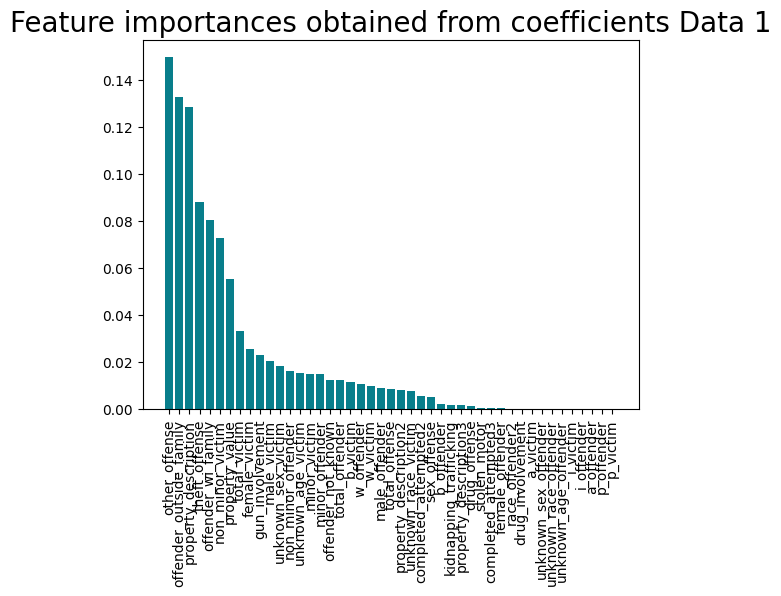

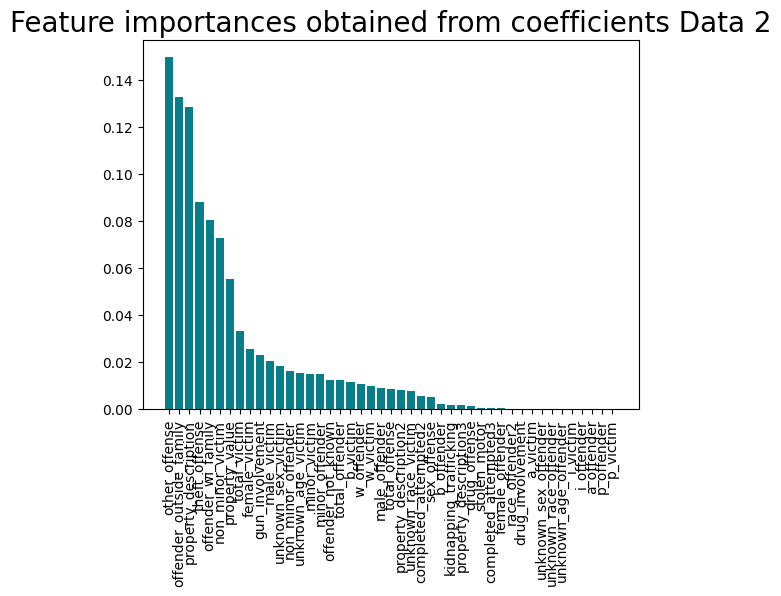

In [ ]:
plt.bar(x=rf_importances1['Attribute'], height=rf_importances1['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients Data 1', size=20)
plt.xticks(rotation='vertical')
plt.show()

plt.bar(x=rf_importances2['Attribute'], height=rf_importances2['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients Data 2', size=20)
plt.xticks(rotation='vertical')
Above plt.show()

Above is a full visualization of the priorities based on our random forests.

To analyze this narrative, we ran a Naive Bayes system on each train-test split to create predictive models for further correlation discovery on all the crimes in the data.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import warnings
# Intiate a standard scaler and naive bayes
ss = StandardScaler()
naive_bayes = GaussianNB()
warnings.filterwarnings('ignore', message='X does not have valid feature names')
pca = PCA(n_components=0.95)

# Naive Bayes function calculator
def Naive_Bayes(X_train, y_train , X_test, y_test):
  #Calculate Naive Baye's Analysis
  nb_model = naive_bayes.fit(X_train, y_train)
  y_pred = nb_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

# Scaling function calculator
def Scaling(X_train, y_train , X_test, y_test):
  X_train_scaled = ss.fit_transform(X_train)
  X_test_scaled = ss.transform(X_test)
  # Calculate Naive Baye's Analysis
  nb_model = naive_bayes.fit(X_train_scaled, y_train)
  y_pred = nb_model.predict(X_test_scaled)
  # Calculate F1 Score
  f1 = f1_score(y_test, y_pred, average='weighted')
  # The average weighted considers label imbalance
  return f1

naive1 = Naive_Bayes(X1_train, y1_train, X1_test, y1_test)
naive2 = Naive_Bayes(X2_train, y2_train, X2_test, y2_test)
scaling1 = Scaling(X1_train, y1_train, X1_test, y1_test)
scaling2 = Scaling(X2_train, y2_train, X2_test, y2_test)
print(f'Naive Bayes Analysis of Data 1: {naive1}')
print(f'Naive Bayes Analysis of Data 2: {naive2}')
print(f'F1 Score data 1(weighted): {scaling1}')
print(f'F1 Score data 2 (weighted): {scaling2}')

#Scaling the data in order to predict the model for naive bayes model prediction


Naive Bayes Analysis of Data 1: 0.8181908779855829
Naive Bayes Analysis of Data 2: 0.16916266666666666
F1 Score data 1(weighted): 0.9124682882131422
F1 Score data 2 (weighted): 0.8840041742568799


The Naive Bayes analysis for Data 1 gave 0.8181, with a F1 score of 0.9125, which indicates that the model performed well and correctly classified around 82% of the cases.

However, the Naive Bayes analysis for Data 2 showed a much lower accuracy of 0.1691 and a F1 score of 0.8840, which suggests that the model struggled  with this subset, this is likley due to differences in data distribution  of the two chunks. This is likely due to the fact when splitting this chunked data and running a seperate test train split the second dataset may have contained information that are related to petty crimes that aren't related to violence.

Therefore, indiciating the lower Naive Bayes score yet having the F1 score being shows that the model can be precise, but not accurate due to the nature of the split data.

Further extrapolating from our PCA data. We've noticed a lot of the unknown columns were deemed unimportant so we removed unimportant columns from the dataset and decided to run another test train split on it to further reduce any RAM usage by dimensionality reduction.

In [ ]:
# Dropping specific columns for X3
X1 = df1.drop([
    'violence_offense',
    'unknown_race_offender',
    'unknown_sex_offender',
    'unknown_age_offender',
    'drug_involvement',
    'a_offender',
    'p_victim'
], axis=1)  # Add or remove columns as needed
y1 = df1['violence_offense']

# Dropping specific columns for X4
X2 = df2.drop([
    'violence_offense',
    'unknown_race_offender',
    'unknown_sex_offender',
    'unknown_age_offender',
    'drug_involvement',
    'a_offender',
    'p_victim'
], axis=1)  # Add or remove columns as needed
y2 = df2['violence_offense']

X1_train, X1_test, y1_train, y1_test = data_trainer(X1, y1)
X2_train, X2_test, y2_train, y2_test = data_trainer(X2, y2)

In [ ]:
naive1 = Naive_Bayes(X1_train, y1_train, X1_test, y1_test)
naive2 = Naive_Bayes(X2_train, y2_train, X2_test, y2_test)
scaling1 = Scaling(X1_train, y1_train, X1_test, y1_test)
scaling2 = Scaling(X2_train, y2_train, X2_test, y2_test)
print(f'Naive Bayes Analysis of Data 1 after PCA: {naive1}')
print(f'Naive Bayes Analysis of Data 2 after PCA: {naive2}')
print(f'F1 Score data 1(weighted) after PCA: {scaling1}')
print(f'F1 Score data 2 (weighted) after PCA: {scaling2}')

Naive Bayes Analysis of Data 1 after PCA: 0.8181908779855829
Naive Bayes Analysis of Data 2 after PCA: 0.16916266666666666
F1 Score data 1(weighted) after PCA: 0.8863374296524948
F1 Score data 2 (weighted) after PCA: 0.8697042033475552


After training the dataset again and did another Naive Bayes and F1 analysis we noticed an actual decrease in performance.
This implies that the PCA might consider a column as redundant because its information may not provide intensively new information, however, the dropped column may introduce nuanced information that the model depends on, so the decrease in performance occurs. The analysis had a harder time determining if the nature of the crime was violent or not. The other conclusion could be that the PCA analysis was incomplete, and therefore, removed seemingly incompatible variables given that we only used a portion of the full data.

This data ultimately stores a major amount of crime incidents. We could have used the total crime data points for any number of analyses, but we were specifically interested in the violence of crime because of how often we seem to see violent crime represented in the news. Could the media be over representing the true nature of crime, or is humanity actually becoming increasingly violent? We wanted to describe an aspect of this philosophical inquiry by analyzing how easily we could predict whether or not a crime was a "violent offense" based on the other factors of that crime. This is obviously a highly imperfect analysis because the data itself is arbitrary in its record, but this gives us a basic estimate to begin understanding the reality.

Through our analysis, we found that features such as 'other_offense', 'property_description', 'offender_outside_of_family', and 'theft_offense' significantly contributed to identifying violent undertones in crimes. This could be explained by the fact that most crimes are violent regardless, so the large *miscallaneous* factor of the "other offense" was a large predictor. Next, the property involvement may reveal that there is a larger chance violence and passion could be involved with property potentially because of modern day housing prices and asset economics. Lastly, the fact that the criminal being non related to an individual could show us that humanity is becoming increasingly separated and less willing to understand strangers. This is supported with the consistent political polarization of society in America, in addition to the overall uptick in crimes across the country in the last decade.

Our analysis overall showed the nuance needed to handle large datasets.  While PCA and chunking were crucial in managing data size, the balance between dimensionality reduction and not losing key informative remains vital for maintaining model performance and delivering accurate information.

Future works ahead should focus on exploring additional streageties to handle the diverse nature of huge datasets.

In [ ]:
def colab2pdf():

   ENABLE=True # @param {type:"boolean"}

   if ENABLE:

       import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings

       locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

       NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))

       TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)

       NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]

       warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)

       with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)

       if not pathlib.Path("/usr/local/bin/quarto").exists():

           !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet

       with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)

       !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet

       google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>